In [1]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F

# Utils
import numpy as np
from numpy import ndarray
import logging, math


# Base Scripts
from Libraries.Utils import *
from Libraries.U_Net import *
from Libraries.Diffusion import *
from Libraries.VAE import MultiResolutionSTFTLoss

## Setup

### Initial Setup

In [2]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
model_name: str = "WaveDiffusion_v1"
full_model_path: str = OS().path_to_remote_path("../Models/{}.pth".format(model_name), remote_kernel)

### Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [4]:
n_samples: int = 4096
batch_size: int = 12
n_workers: int = 1

### Data loading

In [5]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split(n_samples)
train_datatset, val_dataset = md.create_datasets()
train_dataloader, val_dataloader = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")

2025-08-26 09:18:48,230 - INFO - Created train dataset with length 4096 and validation dataset with length 204


In [6]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-08-26 09:18:48,828 - INFO - Created test dataset with length 268


## Model Setup

### Hyperparameters

In [7]:
b1, b2 = (0.9, 0.99)
lr: float = 1e-4
n_epochs: int = 120
checkpoint_freq: int = 15
lr_restart_period: int = 30
restart_training: bool = True

### Models

In [8]:
u_net = UNet(in_channels=1, n_layers=4, base_channels=32, embed_dim=128).to(device)

### Optimizers & Schedulers

In [9]:
optimizer = optim.AdamW(u_net.parameters(), lr, (b1, b2))
scheduler = optim.lr_scheduler.ConstantLR(optimizer, 1) #optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=lr_restart_period, eta_min=1e-7, T_mult=2)

### Load Model

In [10]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    u_net.load_state_dict(model["u_net"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(u_net)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(u_net)} Parameters")

2025-08-26 09:18:49,998 - INFO - Model WaveDiffusion_v1 created with ~4.76M Parameters


## Training

In [11]:
torch.backends.cudnn.benchmark = True

diffusion = Diffusion(noise_steps=1000, schedule="cosine", v_obj=False, device=device)
loss_fn = nn.MSELoss()

In [12]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0

for e in range(n_epochs):
    total_loss: float = 0
    start_time: float = time.time()

    for b_idx, (audio, _) in enumerate(train_dataloader):
        audio: Tensor = audio.to(device)
        if audio.ndim == 2:
            audio = audio.unsqueeze(1)
        x_t, noise, t = diffusion.prep_train_ddxm(audio)
        with torch.autocast(device):
            noise_recon = u_net(x_t, t)
            loss = loss_fn(noise, noise_recon)
        if loss.isnan():
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
    else:
        u_net.eval()
        total_val_loss: float = 0
        for x,_ in val_dataloader:
            audio: Tensor = audio.to(device)
            if audio.ndim == 2:
                audio = audio.unsqueeze(1)
            x_t, noise, t = diffusion.prep_train_ddxm(audio)
            with torch.no_grad():
                noise_recon = u_net(x_t, t)
                total_val_loss += loss_fn(noise, noise_recon)
        #plt.plot((x_t - noise_recon)[1][0].cpu().numpy())
        #plt.show()  
        u_net.train()

        epoch_time = time.time() - start_time
        total_time += epoch_time
        remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
        avg_loss = total_loss / len(train_dataloader)
        avg_val_loss = total_val_loss / len(val_dataloader)
        loss_list.append({"avg_loss": avg_loss, "avg_val_loss": avg_val_loss})
        scheduler.step()

        logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.3e} Avg. Val Loss: {avg_val_loss:.3e} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.4e}")

        if checkpoint_freq > 0 and (e + 1) % checkpoint_freq == 0:
                checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1:03d}.pth"
                torch.save({"u_net": u_net.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, checkpoint_path)
                if e + 1 != checkpoint_freq:
                    last_path: str = f"{full_model_path[:-4]}_epoch_{(e + 1) - checkpoint_freq:03d}.pth"
                    OS().del_if_exists(last_path)
                logger.light_debug(f"Checkpoint saved model to {checkpoint_path}")
        continue
    break
else:
    torch.save({"u_net": u_net.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)
    logger.light_debug(f"Saved model to {full_model_path}")

    if checkpoint_freq > 0:
        checkpoint_path: str = f"{full_model_path[:-4]}_epoch_{e + 1 - ((e + 1) % checkpoint_freq):03d}.pth"
        OS().del_if_exists(checkpoint_path)

2025-08-26 09:18:50,251 - INFO - Training started on cuda
2025-08-26 09:29:48,789 - INFO - Epoch 006: Avg. Loss: 1.391e-01 Avg. Val Loss: 1.669e-01 Remaining Time: 03h 28min 32s LR: 1.0000e-04
2025-08-26 09:31:37,726 - INFO - Epoch 007: Avg. Loss: 1.472e-01 Avg. Val Loss: 5.083e-01 Remaining Time: 03h 26min 29s LR: 1.0000e-04
2025-08-26 09:33:26,642 - INFO - Epoch 008: Avg. Loss: 1.654e-01 Avg. Val Loss: 3.800e-01 Remaining Time: 03h 24min 29s LR: 1.0000e-04
2025-08-26 09:35:15,616 - INFO - Epoch 009: Avg. Loss: 1.617e-01 Avg. Val Loss: 1.601e-01 Remaining Time: 03h 22min 32s LR: 1.0000e-04
2025-08-26 09:37:04,571 - INFO - Epoch 010: Avg. Loss: 1.977e-01 Avg. Val Loss: 1.702e-01 Remaining Time: 03h 20min 37s LR: 1.0000e-04
2025-08-26 09:38:53,528 - INFO - Epoch 011: Avg. Loss: 1.571e-01 Avg. Val Loss: 5.882e-01 Remaining Time: 03h 18min 43s LR: 1.0000e-04
2025-08-26 09:40:42,546 - INFO - Epoch 012: Avg. Loss: 1.980e-01 Avg. Val Loss: 1.347e-01 Remaining Time: 03h 16min 50s LR: 1.0000e-

: 

In [ ]:
out = diffusion.bwd_diffusion_ddpm(u_net, [10, 1, 262144])
plt.plot(out[1][0])
plt.show()  

2025-08-26 09:05:00,422 - INFO - Started sampling 10 samples on cuda
2025-08-26 09:11:58,635 - INFO - Created 10 samples


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

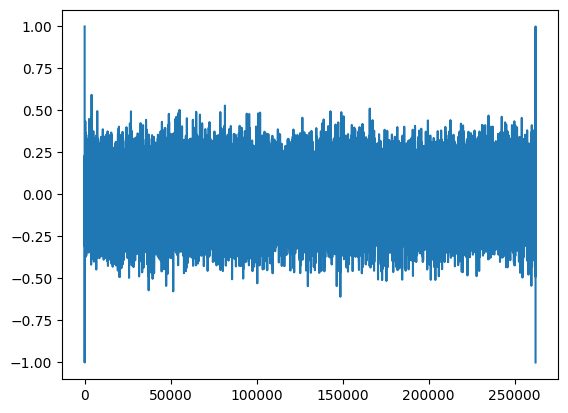

In [ ]:

out = torch.clamp(Tensor(out), min=-1, max=1).cpu().numpy()
plt.plot(out[4][0])
plt.show()  